In [1]:
#sets working directory. You will need to change this to the directory
#where your data are stored on your computer
%pwd

'C:\\Users\\Adam\\Documents\\NEON'

In [2]:
#verifies the version of Python running on your computer. This script was developed using Py 3.4
import sys
sys.version

'3.4.5 |Anaconda custom (64-bit)| (default, Jul  5 2016, 14:53:07) [MSC v.1600 64 bit (AMD64)]'

In [3]:
#imports the libraries needed for running the script
import gdal  #gdal allows a user to manipulate raster data
import numpy as np #numpy provides mathematical functions for data organized in arrays.
#"as" specifies that functions in numpy can be called up using "np"

import h5py #h5py interfaces to the HDF5 file format
import matplotlib.pyplot as plt #matplotlib.pyplot links to a library of plotting functions
#"as" specifies  that functions in matplotlib.pyplot can be called up using "plt"

#sets plots to be displayed in line in the code, not as a separate window/file.
%matplotlib inline 
import warnings #accesses the warnings library to provide functions for providing warnings to users
warnings.filterwarnings('ignore') #sets script to ignore warnings

In [25]:
import neon_aop_refl_hdf5_functions as neon #imports NEON's AOP reflectance library of functions
#"as" specifies that functions in this library can be called up using "neon"

In [ ]:
# %load neon_aop_refl_hdf5_functions
# %load neon_aop_refl_hdf5_functions
"""
Created on Mon Feb  6 16:36:10 2017

@author: bhass

neon_aop_refl_hdf5_functions contains the following functions for use in the 
Remote Sensing Data Institute (June 19-25, 2017)

list_dataset (called with h5py.File.visititems):
    lists the name and location of each dataset stored in an hdf5 file 

ls_dataset (called with h5py.File.visititems):
    lists name, shape, and type of each dataset stored in an hdf5 file

h5refl2array(refl_filename): 
    reads in a NEON AOP reflectance hdf5 file and returns reflectance array, 
    select metadata, and wavelength dataset

extract_raw_band(reflArray,reflArray_metadata,band_ind):
    extracts a single band from a reflectance array without applying the scale 
    factor or data ignore value

clean_band(bandArray,reflArray_metadata):
    sets the data ignore value to NaN and applies the scale factor to a single 
    reflectance band array

extract_clean_band(reflArray,reflArray_metadata,band_ind):
    extracts a single band from a reflectance array, applies the scale factor 
    and sets the data ignore value to NaN

plot_band_array(band_array,refl_extent,colorlimit,ax=plt.gca(),title='', \
cmap_title='',colormap='spectral'):
    reads in and plots a single band of a reflectance array, or plots three 
    bands as an RGB image

array2raster(newRaster,reflBandArray,reflArray_metadata): 
    reads in a reflectance array and associated metadata and returns a geotif 
    raster named newRaster.tif

calc_clip_index(clipExtent, h5Extent, xscale=1, yscale=1):
    calculates the indices relative to a full flight line extent of a subset 
    given a clip extent in UTM m (x,y)
    
subset_clean_refl(reflArray,reflArray_metadata,clipIndex):
    subsets a reflectance array to the specified clipIndex, and applies the no 
    data value and scale factor

stack_clean_bands(reflArray,reflArray_metadata,bands):
    generates an array of multiple bands, and applies the data ignore value and 
    scale factor to each band
    
subset_clean_band(reflArray,reflArray_metadata,clipIndex,bandIndex):
    extracts a band from a reflectance array, subsets it to the specified 
    clipIndex, and applies the no data value and scale factor
    
stack_subset_bands(reflArray,reflArray_metadata,bands,clipIndex):
    subsets, cleans, and stacks specified bands from a reflectance array

"""

#Import Required Packages:
import numpy as np
import matplotlib.pyplot as plt
import h5py, gdal, osr, copy

def list_dataset(name,node):
    
    """list_dataset lists the name and location of each dataset stored in an hdf5 file.
    --------
    See Also
    --------
    ls_dataset: 
        Lists name, shape, and type of each dataset stored in an hdf5 file.
    Example:
    --------
    f = h5py.File('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5','r') 
    f.visititems(list_dataset)"""
    
    if isinstance(node, h5py.Dataset):
        print(name)

def ls_dataset(name,node):
    
    """ls_dataset lists the name, shape, and datatype of each dataset stored in 
    an hdf5 file.
    --------
    See Also
    --------
    list_dataset: 
        Lists name and location of each dataset stored in an hdf5 file
    Example:
    --------
    f = h5py.File('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5','r') 
    f.visititems(ls_dataset)"""
    
    if isinstance(node, h5py.Dataset):
        print(node)

def h5refl2array(refl_filename):
    """h5refl2array reads in a NEON AOP reflectance hdf5 file and returns 
    reflectance array, select metadata, and wavelength dataset.
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata:
            EPSG: coordinate reference system code (integer)
            *bad_band_window1: [1340 1445] range of wavelengths to ignore
            *bad_band_window2: [1790 1955] range of wavelengths to ignore 
            ext_dict: dictionary of spatial extent 
            extent: array of spatial extent (xMin, xMax, yMin, yMax)
            mapInfo: string of map information 
            *noDataVal: -9999.0
            projection: string of projection information
            *res: dictionary containing 'pixelWidth' and 'pixelHeight' values (floats)
            *scaleFactor: 10000.0
            shape: tuple of reflectance shape (y, x, # of bands)
        * Asterixed values are the same for all NEON AOP hyperspectral reflectance 
        files processed 2016 & after.
    wavelengths:
        Wavelengths dataset. This is the same for all NEON AOP reflectance hdf5 files.
        wavelengths.value[n-1] gives the center wavelength for band n 
    --------
    This function applies to the NEON hdf5 format implemented in 2016, which 
    applies to data acquired in 2016 & 2017 as of June 2017. Data in earlier 
    NEON hdf5 format is expected to be re-processed after the 2017 flight season. 
    --------
    Example
    --------
    sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5') """
    
    #Read in reflectance hdf5 file (include full or relative path if data is located in a different directory)
    hdf5_file = h5py.File(refl_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    reflArray = refl['Reflectance_Data']
    refl_shape = reflArray.shape
    wavelengths = refl['Metadata']['Spectral_Data']['Wavelength']
    
    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['shape'] = reflArray.shape
    metadata['mapInfo'] = refl['Metadata']['Coordinate_System']['Map_Info'].value

    #Extract no data value & set no data value to NaN
    metadata['noDataVal'] = float(reflArray.attrs['Data_Ignore_Value'])
    metadata['scaleFactor'] = float(reflArray.attrs['Scale_Factor'])
    
    #Extract bad band windows
    metadata['bad_band_window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad_band_window2'] = (refl.attrs['Band_Window_2_Nanometers'])
    
    #Extract projection information
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    
    #Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value
    mapInfo_string = str(mapInfo); 
    mapInfo_split = mapInfo_string.split(",")
    
    #Extract the resolution & convert to floating decimal number
    metadata['res'] = {}
    metadata['res']['pixelWidth'] = float(mapInfo_split[5])
    metadata['res']['pixelHeight'] = float(mapInfo_split[6])
    
    #Extract the upper left-hand corner coordinates from mapInfo
    xMin = float(mapInfo_split[3]) #convert from string to floating point number
    yMax = float(mapInfo_split[4])
    #Calculate the xMax and yMin values from the dimensions
    xMax = xMin + (refl_shape[1]*metadata['res']['pixelWidth']) #xMax = left edge + (# of columns * resolution)",
    yMin = yMax - (refl_shape[0]*metadata['res']['pixelHeight']) #yMin = top edge - (# of rows * resolution)",
    metadata['extent'] = (xMin,xMax,yMin,yMax) #useful format for plotting
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = xMin
    metadata['ext_dict']['xMax'] = xMax
    metadata['ext_dict']['yMin'] = yMin
    metadata['ext_dict']['yMax'] = yMax
    hdf5_file.close        
    
    return reflArray, metadata, wavelengths
    
def extract_raw_band(reflArray,reflArray_metadata,band_ind):
    
    """extract_raw_band extracts a single band from a reflectance array without applying the scale factor or data ignore value.
     --------
    Parameters
    --------
        reflArray: array of reflectance values, created from h5refl2array function
        reflArray_metadata: reflectance metadata values, created from h5refl2array function
        band_ind: index of wavelength band to be extracted
    --------
    Returns 
        bandArray: array of single band, without scale factor or data ignore value applied. 
    --------
    See Also
    --------
    clean_band: 
        Applies the data ignore value and scale factor to a single band array of reflectance data.
    extract_clean_band:
        Extracts a single band of data from a reflectance array and applies the data ignore value and scale factor.
    Example:
    --------
    SERC_b56_raw = extract_raw_band(sercRefl,sercRefl_md,56) """
    
    bandArray = reflArray[:,:,band_ind-1].astype(np.float)
    return bandArray 

def clean_band(bandArray,reflArray_metadata):
        
    """clean_band sets the data ignore value to NaN and applies the scale factor to a single reflectance band array.
     --------
    Parameters
    --------
        bandArray: array of single band of reflectance values, created from extract_raw_band function
        reflArray_metadata: reflectance metadata values, created from h5refl2array function
    --------
    Returns 
        band_clean: array of single band, with scale factor applied and data ignore value set to NaN.
    --------
    See Also
    --------
    extract_raw_band: 
        Extracts a single band from a reflectance array without applying the scale factor or data ignore value.
    extract_clean_band:
        Extracts a single band of data from a reflectance array and applies the data ignore value and scale factor.
    Example:
    --------
    SERC_b56_clean = clean_band(SERC_b56_raw,sercRefl_md) """
    
    band_clean = copy.copy(bandArray) #make a copy of the array so you don't change the value of the original bandArray
    band_clean[band_clean==int(reflArray_metadata['noDataVal'])]=np.nan
    band_clean = band_clean/reflArray_metadata['scaleFactor']
    return band_clean

def extract_clean_band(reflArray,reflArray_metadata,band_ind):
    
    """extract_clean_band extracts a single band from a reflectance array, 
    applies the scale factor and sets the data ignore value to NaN.
    --------
    Parameters
    --------
        reflArray: array of reflectance values, created by h5refl2array function
        reflArray_metadata: reflectance metadata values, created by h5refl2array 
        band_ind: index of wavelength band to be extracted
    --------
    Returns 
        bandCleaned: array of single band, with scale factor applied and data ignore value set to NaN. 
    --------
    See Also
    --------
    extract_raw_band:
        Extracts a single band of data from a reflectance array and applies the 
        data ignore value and scale factor.
    clean_band:
        Applies the scale factor and sets the data ignore value to NaN for a 
        single reflectance band. 
    Example:
    --------
    SERC_b56_clean = extract_clean_band(sercRefl,sercRefl_md,56) """
    
    bandArray = reflArray[:,:,band_ind-1].astype(np.float)
    bandCleaned = copy.copy(bandArray)
    bandCleaned[bandCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    bandCleaned = bandCleaned/reflArray_metadata['scaleFactor']
    return bandCleaned   

def plot_band_array(band_array,refl_extent,colorlimit,ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='spectral'):
    
    '''plot_band_array reads in and plots a single band of a reflectance array
    --------
    Parameters
    --------
        band_array: flightline array of reflectance values, created from h5refl2array function
        refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) - use metadata['extent'] from h5refl2array function
        colorlimit: range of values to plot (min,max). Best to look at the histogram of reflectance values before plotting to determine colorlimit.
        ax: optional, default = current axis
        title: string, optional; plot title
        cmap_title: string, optional; colorbar title
        colormap: string, optional; see https://matplotlib.org/examples/color/colormaps_reference.html for list of colormaps
    --------
    Returns 
        plots flightline array of single band of reflectance data
    --------
    See Also
    --------
    plot_subset_band:
        plots a subset of a full flightline reflectance band array 
    Example:
    --------
    plot_band_array(SERC_b56_clean,sercRefl_md['extent'],(0,0.3),ax,title='SERC Band 56 Reflectance',cmap_title='Reflectance',colormap='spectral') ''' 
    
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

def array2raster(newRaster,reflBandArray,reflArray_metadata): 
    
    '''array2raster reads in a reflectance array and associated metadata and returns a geotif raster named newRaster.tif
    --------
    Parameters
    --------
        newRaster: string, name of new geotif raster created
        reflBandArray: reflectance array to be converted to raster
        reflArray_metadata: reflectance metadata associated with reflectance array (generated by h5refl2array function)
    --------
    Returns 
        newRaster.tif: geotif raster created from reflectance array and associated metadata
    --------
    See Also
    --------
    h5refl2array: 
        reads in a NEON hdf5 reflectance file and returns the reflectance array, select metadata, and the wavelength dataset
    Example:
    --------
    array2raster('SERC_b56_clean.tif',SERC_b56_clean,sercRefl_md) ''' 
    
    cols = reflBandArray.shape[1]
    rows = reflBandArray.shape[0]
    pixelWidth = float(reflArray_metadata['res']['pixelWidth'])
    pixelHeight = -float(reflArray_metadata['res']['pixelHeight'])
    originX = reflArray_metadata['ext_dict']['xMin']
    originY = reflArray_metadata['ext_dict']['yMax']
    
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create('hopb_b56.tif', cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(reflBandArray)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(reflArray_metadata['epsg']) 
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

def calc_clip_index(clipExtent, h5Extent, xscale=1, yscale=1):
    
    '''calc_clip_index calculates the indices relative to a full flight line extent of a subset given a clip extent in UTM m (x,y)
    --------
    Parameters
    --------
        clipExtent: dictionary of extent of region 
        h5Extent: dictionary of extent of h5 file (from the h5refl2array function, this corresponds to metadata['ext_dict'])
        xscale: optional, pixel size in the x-dimension, default is 1m (applicable to NEON reflectance data)
        yscale: optional, pixel size in the y-dimension, default is 1m (applicable to NEON reflectance data)
    --------
    Returns 
        newRaster.tif: geotif raster created from reflectance array and associated metadata
    --------
    Notes
    --------
    The clipExtent must lie within the extent of the h5Extent for this function to work. 
    If clipExtent exceets h5Extent in any direction, the function will return an error message. 
    --------
    Example:
    --------
    clipExtent = {'xMax': 368100.0, 'xMin': 367400.0, 'yMax': 4306350.0, 'yMin': 4305750.0}
    calc_clip_index(clipExtent, sercRefl, xscale=1, yscale=1) ''' 
    
    h5rows = h5Extent['yMax'] - h5Extent['yMin']
    h5cols = h5Extent['xMax'] - h5Extent['xMin']    
    
    ind_ext = {}
    ind_ext['xMin'] = round((clipExtent['xMin']-h5Extent['xMin'])/xscale)
    ind_ext['xMax'] = round((clipExtent['xMax']-h5Extent['xMin'])/xscale)
    ind_ext['yMax'] = round(h5rows - (clipExtent['yMin']-h5Extent['yMin'])/xscale)
    ind_ext['yMin'] = round(h5rows - (clipExtent['yMax']-h5Extent['yMin'])/yscale)
    
    return ind_ext

def subset_clean_refl(reflArray,reflArray_metadata,clipIndex):
    
    '''subset_clean_refl subsets a reflectance array to the specified clipIndex, and applies the no data value and scale factor
    --------
    Parameters
    --------
        reflArray: reflectance array of dimensions (y,x,426) from which multiple bands (typically 3) are extracted
        reflArray_metadata: reflectance metadata associated with reflectance array (generated by h5refl2array function)
        clipIndex: ditionary; indices relative to a full flight line extent of a subset given a clip extent (generated by calc_clip_index function)
    --------
    Returns 
        reflSubCleaned: array of subsetted reflectance with no data value set to NaN and scale factor applied
    --------
    See Also
    --------
    h5refl2array: 
        reads in a NEON hdf5 reflectance file and returns the reflectance array, select metadata, and the wavelength dataset
    calc_clip_index:
        calculates the indices relative to a full flight line extent of a subset given a clip extent in UTM m (x,y)
    --------
    Example:
    --------
    sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5')
    clipExtent = {'xMax': 368100.0, 'xMin': 367400.0, 'yMax': 4306350.0, 'yMin': 4305750.0}
    serc_subInd = calc_clip_index(clipExtent,sercRefl_md['ext_dict']) 
    
    serc_subset = subset_clean_band(sercRefl,sercRefl_md,serc_subInd) '''
    
    reflSubCleaned = reflArray[clipIndex['yMin']:clipIndex['yMax'],clipIndex['xMin']:clipIndex['xMax'],:].astype(np.float)
    reflSubCleaned[reflSubCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    reflSubCleaned = reflSubCleaned/reflArray_metadata['scaleFactor']
    return reflSubCleaned

def stack_clean_bands(reflArray,reflArray_metadata,bands):
        
    '''stack_clean_bands generates an array of three bands, and applies the data ignore value and scale factor to each band
    --------
    Parameters
    --------
        reflArray: reflectance array of dimensions (y,x,426) from which three bands are extracted
        reflArray_metadata: reflectance metadata associated with reflectance array (generated by h5refl2array function)
        bands: indices of bands to be stacked; bands must be between 0-426 (eg. bands=(60,30,20))
    --------
    Returns 
        stackedArray: array of stacked bands
    --------
    Notes
    --------
    See Also
    --------
    h5refl2array: 
        reads in a NEON hdf5 reflectance file and returns the reflectance array, select metadata, and the wavelength dataset
    --------
    Example:
    --------
    sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5')
    RGBbands = (58,34,19)
    sercRGBarray = stack_clean_bands(sercRefl,sercRefl_md,RGBbands) ''' 
    
    band_clean_dict = {}
    band_clean_names = []

    stackedArray = np.zeros((reflArray.shape[0],reflArray.shape[1],len(bands)),'uint8') #pre-allocate stackedArray matrix
    
    for i in range(len(bands)):
        band_clean_names.append("b"+str(bands[i])+"_refl_clean")
        band_clean_dict[band_clean_names[i]] = extract_clean_band(reflArray,reflArray_metadata,bands[i])
        stackedArray[...,i] = band_clean_dict[band_clean_names[i]]*256
                        
    return stackedArray

def subset_clean_band(reflArray,reflArray_metadata,clipIndex,bandIndex):
    
    '''subset_clean_band extracts a band from a reflectance array, subsets it to the specified clipIndex, and applies the no data value and scale factor
    --------
    Parameters
    --------
        reflArray: reflectance array of dimensions (y,x,426) from which multiple bands (typically 3) are extracted
        reflArray_metadata: reflectance metadata associated with reflectance array (generated by h5refl2array function)
        clipIndex: ditionary; indices relative to a full flight line extent of a subset given a clip extent (generated by calc_clip_index function)
        bandIndex: band number to be extracted (integer between 1-426)
    --------
    Returns 
        bandCleaned: array of subsetted band with no data value set to NaN and scale factor applied
    --------
    See Also
    --------
    h5refl2array: 
        reads in a NEON hdf5 reflectance file and returns the reflectance array, select metadata, and the wavelength dataset
    calc_clip_index:
        calculates the indices relative to a full flight line extent of a subset given a clip extent in UTM m (x,y)
    --------
    Example:
    --------
    sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5')
    clipExtent = {'xMax': 368100.0, 'xMin': 367400.0, 'yMax': 4306350.0, 'yMin': 4305750.0}
    serc_subInd = calc_clip_index(clipExtent,sercRefl_md['ext_dict']) 
    
    serc_b58_subset = subset_clean_band(sercRefl,sercRefl_md,serc_subInd,58) '''
    
    bandCleaned = reflArray[clipIndex['yMin']:clipIndex['yMax'],clipIndex['xMin']:clipIndex['xMax'],bandIndex-1].astype(np.float)
    bandCleaned[bandCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    bandCleaned = bandCleaned/reflArray_metadata['scaleFactor']
    
    return bandCleaned 

def stack_subset_bands(reflArray,reflArray_metadata,bands,clipIndex):
    
    '''stack_subset_bands subsets, cleans, and stacks specified bands from a reflectance array
    --------
    Parameters
    --------
        reflArray: reflectance array of dimensions (y,x,426) from which multiple bands (typically 3) are extracted
        reflArray_metadata: reflectance metadata associated with reflectance array (generated by h5refl2array function)
        bands: indices of bands to be stacked; bands must be between 0-426 (eg. bands=(60,30,20))
        clipIndex: indices relative to a full flight line extent of a subset given a clip extent, (generated by calc_clip_index function)
    --------
    Returns 
        stackedArray: array of subsetted, stacked bands with no data value set to NaN and scale factor applied
    --------
    See Also
    --------
    h5refl2array: 
        reads in a NEON hdf5 reflectance file and returns the reflectance array, select metadata, and the wavelength dataset
    calculcate_clip_index:
        calculates the indices relative to a full flight line extent of a subset given a clip extent in UTM m (x,y)
    subset_clean_band:
        extracts, subsets, and cleans a single band from a reflectance array
    --------
    Example:
    --------
    sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5')
    RGBbands = (58,34,19)
    clipExtent = {'xMax': 368100.0, 'xMin': 367400.0, 'yMax': 4306350.0, 'yMin': 4305750.0}
    serc_subInd = calc_clip_index(clipExtent,sercRefl_md['ext_dict']) 
    
    sercRGBarray = stack_subset_bands(sercRefl,sercRefl_md,RGBbands,serc_subInd) ''' 

    subArray_rows = clipIndex['yMax'] - clipIndex['yMin']
    subArray_cols = clipIndex['xMax'] - clipIndex['xMin']
    
    stackedArray = np.zeros((subArray_rows,subArray_cols,len(bands)),'uint8') #pre-allocate stackedArray matrix
    band_clean_dict = {}
    band_clean_names = []
    
    for i in range(len(bands)):
        band_clean_names.append("b"+str(bands[i])+"_refl_clean")
        band_clean_dict[band_clean_names[i]] = subset_clean_band(reflArray,reflArray_metadata,clipIndex,bands[i])
        stackedArray[...,i] = band_clean_dict[band_clean_names[i]]*256
                        
    return stackedArray

In [28]:
#stores the reflectance values from the HDF5 file as "f"
f = h5py.File('../NEON/NEON_D02_SERC_DP1_20160807_160559_reflectance.h5','r')

In [29]:
#finds the directory SERC/Reflectance and sets it to "serc_refl"
serc_refl = f['SERC']['Reflectance']
print(serc_refl)

<HDF5 group "/SERC/Reflectance" (2 members)>


In [30]:
#displays the dimensions of the flightlines (x, y) and number of bands in "serc_reflArray"
serc_reflArray = serc_refl['Reflectance_Data']
print(serc_reflArray)

<HDF5 dataset "Reflectance_Data": shape (10852, 1106, 426), type "<i2">


In [31]:
#extracts the wavelength information and stores it in "wavelengths"
wavelengths = serc_refl['Metadata']['Spectral_Data']['Wavelength'] 
print(wavelengths)

<HDF5 dataset "Wavelength": shape (426,), type "<f8">


In [21]:
#extracts the reflectance data and stores it in the array
serc_reflArray = serc_refl['Reflectance_Data']
print(serc_reflArray)

<HDF5 dataset "Reflectance_Data": shape (10852, 1106, 426), type "<i2">


In [32]:
#stores the reflectance and wavelength values from the reflectance file in an array
sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5')

In [33]:
#sorts the wavelength values in ascending order and displays each item of associated metadata
for item in sorted(sercRefl_md):
    print(item + ':',sercRefl_md[item])

bad_band_window1: [1340 1445]
bad_band_window2: [1790 1955]
epsg: 32618
ext_dict: {'xMax': 368273.0, 'xMin': 367167.0, 'yMin': 4300128.0, 'yMax': 4310980.0}
extent: (367167.0, 368273.0, 4300128.0, 4310980.0)
mapInfo: b'UTM, 1.000, 1.000, 367167.000, 4310980.000, 1.0000000000e+000, 1.0000000000e+000, 18, North, WGS-84, units=Meters'
noDataVal: -9999.0
projection: b'+proj=UTM +zone= 18 +ellps= WGS-84 +datum= WGS-84 +units= units=Meters +no_defs'
res: {'pixelHeight': 1.0, 'pixelWidth': 1.0}
scaleFactor: 10000.0
shape: (10852, 1106, 426)


In [34]:
#using the HDFView v.2.13, band 58/34/19 isolates red/green/blue wavelengths, respectively.
#the actual wavelength value is n-1
RGBbands = (58,34,19)

print('Band 58 Center wavelength:',wavelengths.value[57])
print('Band 34 Center wavelength:',wavelengths.value[33])
print('Band 19 Center wavelength:',wavelengths.value[18])

Band 58 Center wavelength: 669.0978
Band 34 Center wavelength: 548.9126
Band 19 Center wavelength: 473.7968


In [35]:
#clips the data to a subset with extent of eastings and northings below in the object "clipExtent"
clipExtent = {}
clipExtent['xMin'] = 367400. #period makes number floating point vs integer
clipExtent['xMax'] = 368100.
clipExtent['yMin'] = 4305750.
clipExtent['yMax'] = 4306350.

In [37]:
#calculates the indices of the clipped data and stores it in the object "serc_subInd"
serc_subInd = calc_clip_index(clipExtent,sercRefl_md['ext_dict'])

In [38]:
#displayes the indices
print('SERC Subset Indices:', serc_subInd)

SERC Subset Indices: {'xMax': 933, 'xMin': 233, 'yMin': 4630, 'yMax': 5230}


In [41]:
#stacks the rgb reflectance values in the object "sercSubset_RGB"
sercSubset_RGB = stack_subset_bands(sercRefl,sercRefl_md,RGBbands,serc_subInd)

#displays the dimensions and number of bands in the subset file (three layers of 600 x 700 pixels,
#one for each of the three bands
print(sercSubset_RGB.shape)

(600, 700, 3)


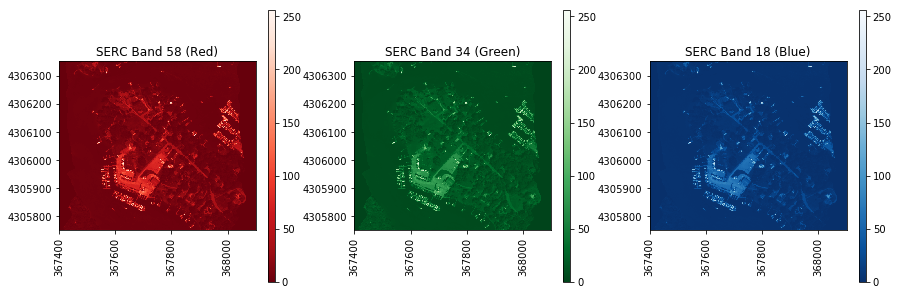

In [42]:
#set color limit from 0-256
colorlimit = (0,256) 

#runs the plt.figure function with dimensions 15 x 5, stores it in object "fig"
fig = plt.figure(figsize=(15,5))

#plot red band in red colormap in first panel
ax1 = fig.add_subplot(1,3,1)
clipExt = (clipExtent['xMin'],clipExtent['xMax'],clipExtent['yMin'],clipExtent['yMax'])
plot_band_array(sercSubset_RGB[:,:,0],clipExt,colorlimit,title='SERC Band 58 (Red)', colormap='Reds_r')

#plot green band in green colormap in second panel
ax2 = fig.add_subplot(1,3,2)
plot_band_array(sercSubset_RGB[:,:,1],clipExt,colorlimit,title='SERC Band 34 (Green)', colormap='Greens_r')

#plot blue band in blue colormap in third panel
ax3 = fig.add_subplot(1,3,3)
plot_band_array(sercSubset_RGB[:,:,2],clipExt,colorlimit,title='SERC Band 18 (Blue)', colormap='Blues_r')

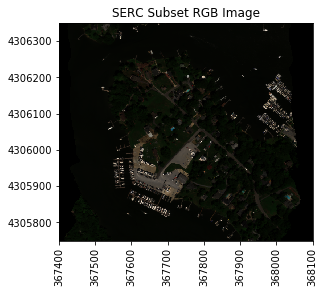

In [43]:
#plot stacked bands in one plot panel.
plot_band_array(sercSubset_RGB,clipExt,(0,0.5),title='SERC Subset RGB Image',cbar='off')

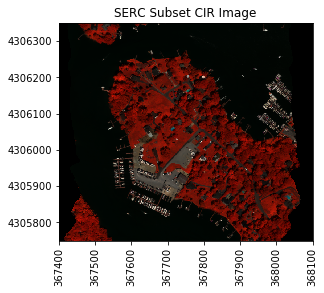

In [44]:
#using HDFView, near-infrared wavelengths are in band 90
CIRbands = (90,34,19)

#use stack_subset_bands function to subset and stack CIR bands defined above
sercSubset_CIR = stack_subset_bands(sercRefl,sercRefl_md,CIRbands,serc_subInd)

#plot with plot_band_array function
plot_band_array(sercSubset_CIR,clipExt,(0,256),title='SERC Subset CIR Image',cbar='off')

In [ ]:
#Enhanced Vegetation Index = 2.5*((NIR - RED)/(NIR + (6*RED) - (7.5*BLUE) + 1))

#NIR = Near Infrared Band (58)
#RED = Red Band (58)
#BLUE = Blue Band 

In [46]:
#define the four bands (blue, green, red, CIR)
evi_bands = (19,58,90) 

#stack into single array using stack_subset_bands function from module
evi_stack = stack_subset_bands(sercRefl,sercRefl_md,evi_bands,serc_subInd)

In [47]:
#setting each band as an object of the wavelengths it represents as float data types.
blue = evi_stack[:,:,0].astype(float)
red = evi_stack[:,:,1].astype(float)
nir = evi_stack[:,:,2].astype(float)

#multiply the red wavelengths by a value of 6
sixRed = 6*red

#multiply the blue wavelengths by a value of 7.5
sevenBlue = 7.5*blue

In [48]:
#calculate EVI
#np.divide is a numpy function for division

evi = 2.5 *(np.divide((nir-red),(nir+sixRed+sevenBlue+1)))

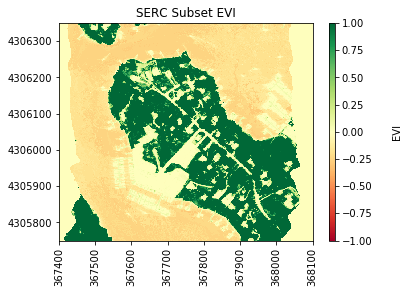

In [50]:
#set range of color values
colorlimit=(-1,1)

#plots image using the evi result, within the clipping extent, using the color limits
plot_band_array(evi,clipExt,colorlimit,title='SERC Subset EVI',cmap_title='EVI',colormap='RdYlGn')